## Configuring the workspace
Assicurarsi di aver installato tutti le librerie necessarie per eseguire gli script all'interno del notebook

In [36]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import statsmodels.api as sm

# Creo la cartella data per salvare i dataset
if not os.path.exists("data"):
    os.makedirs("data")

In [37]:
# Test ADF
def test_ADF(series):
    result = adfuller(series)
    print(f'Statistica del test ADF: {result[0]}')
    print(f'P-value: {result[1]}')
    print('Critical Values:')
    for thres, adf_stat in result[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))

    if result[1] < 0.05:
        print("La serie è stazionaria")
    else:
        print("La serie non è stazionaria")

# Serie temporale di produzione elettrica
Questo dataset è stato preso da [Kaggle](https://www.kaggle.com/datasets/shenba/time-series-datasets?select=Electric_Production.csv).  
Non ha una descrizione particolare, si tratta di valori di produzione elettrica misurata per ogni mese dal 1985 fino al 2018.

In [38]:
name_file="data/Electric_Production.csv"
if not os.path.exists(name_file):
    # Download the dataset
    !kaggle datasets download -d shenba/time-series-datasets -p data
    !unzip data/time-series-datasets.zip -d data

In [39]:
df_data = pd.read_csv(name_file)

# Rinominiamo le colonne per comodità
df_data.rename(columns={"DATE": "date", "IPG2211A2N": "value"}, inplace=True)
# Convertiamo la colonna date in formato datetime
df_data["date"] = pd.to_datetime(df_data["date"])

df_data.head()

,date,value
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [40]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    397 non-null    datetime64[ns]
 1   value   397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


# Controllo valori mancanti

In [41]:
print(f"Intervallo temporale della serie: da {df_data['date'].min()} fino a {df_data['date'].max()}")

Intervallo temporale della serie: da 1985-01-01 00:00:00 fino a 2018-01-01 00:00:00


In [42]:
# Creo un dataframe che contenga tutti i mesi dell'intervallo temporale
df = pd.DataFrame(index=pd.date_range(start=df_data['date'].min(), end=df_data['date'].max(), freq='MS'))

# Aggiungo l'indice temporale al dataset
df_data.set_index(pd.DatetimeIndex(df_data['date']),inplace=True)

# Unisco i due dataset
df = df.merge(df_data, how='left', left_index=True, right_index=True)

# Non ci sono valori mancanti
df.isna().sum()

date     0
value    0
dtype: int64

<Axes: >

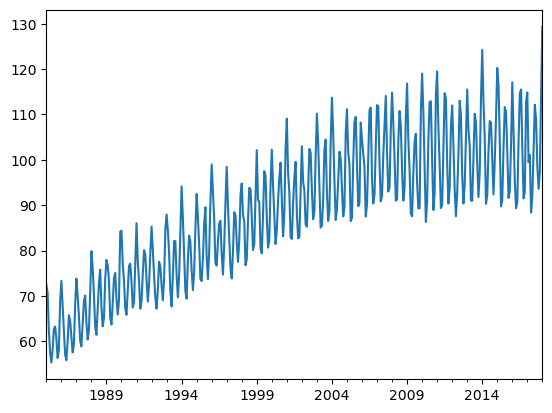

In [43]:
# Visualizzo la serie temporale
df["value"].plot()

# Analisi serie temporale
Ipotizziamo di avere una stagionalità di 12 mesi nella serie temporale.  
Con la tecnica di rolling window cerchiamo di capire l'andamento della curva, la quale sembra avere una tendenza crescente.

Text(0.5, 1.0, 'Rolling Window di 12 mesi')

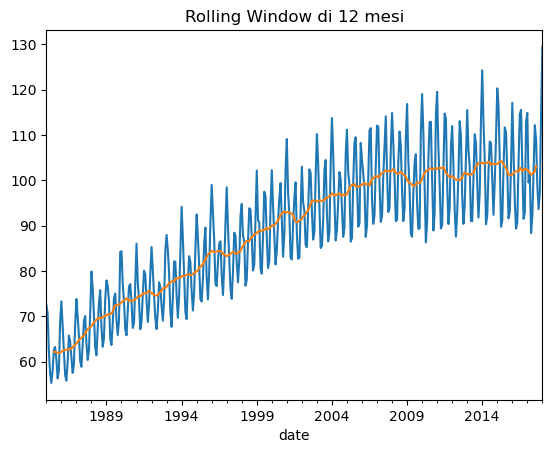

In [44]:
df_data["value"].plot()
df_data["value"].rolling(12,center=True).mean().plot()
plt.title("Rolling Window di 12 mesi")

Dal correlogramma possiamo notare che la serie presenta un andamento decrescente all'aumentare dei lag e delle autocorrelazioni alte fisse che si ripetono.  
Da ciò possiamo dedurre che la serie abbia una tendenza e una stagionalità

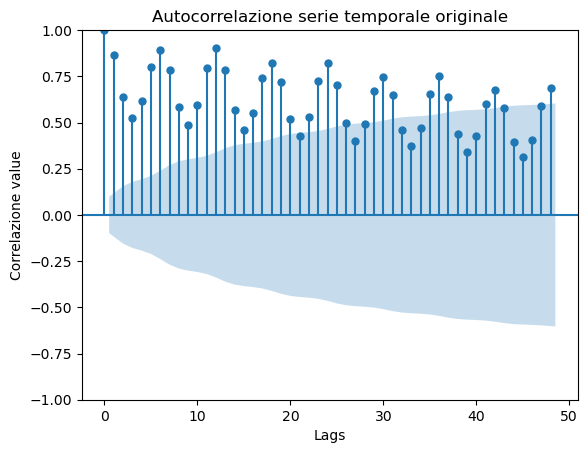

In [45]:
plot_acf(df["value"],lags=48)
plt.title("Autocorrelazione serie temporale originale")
plt.ylabel("Correlazione value")
plt.xlabel("Lags")
plt.show()

Supponiamo di avere un modello additivo per le seguenti ragioni:
- Il trend cresce in modo graduale ma non esponenziale, il che suggerisce un andamento compatibile con un modello additivo.
- La componente stagionale ha un'ampiezza pressoché costante durante tutto il periodo analizzato. Questo è un segnale molto forte che si tratta di un modello additivo, poiché nei modelli moltiplicativi ci si aspetterebbe che l'ampiezza della stagionalità aumenti con l'aumentare del trend.
- I residui sono distribuiti intorno allo zero e non sembrano avere un pattern specifico. Questo è coerente con un modello additivo ben specificato.

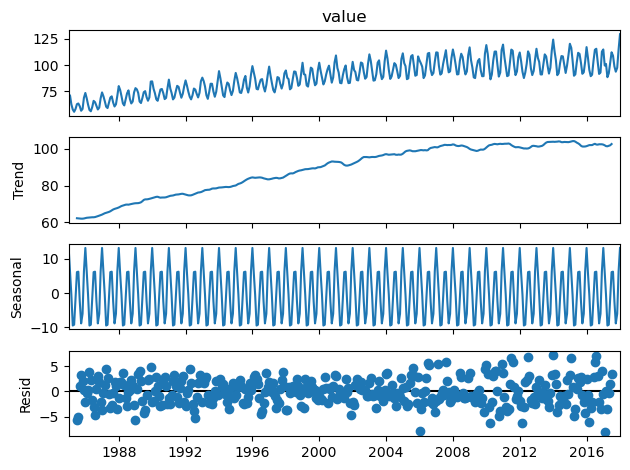

In [46]:
decomposition_additive = seasonal_decompose(df["value"],model='additive')
decomposition_additive.plot()
plt.show()

# Modello di regressione standard
Aggiungiamo delle colonne al nostro dataset originale per indicare meglio l'informazione temporale e la stagione in cui si trova l'esempio.

In [47]:
# Creiamo una variabile che indichi il numero del mese (eliminando la prima variabile dummy per evitare problemi di collinearità)
df['month_no']=df['date'].dt.month
month_vars=pd.get_dummies(df['month_no'], drop_first=True,prefix='m').astype(int)

# concateniamo le colonne dummy al dataset originale
df_regr = pd.concat([df,month_vars], axis=1)

# Aggiungiamo la variabile tempo che considera il numero di giorni dalla prima osservazione
df_regr['time']=df_regr['date'].diff().dt.days.fillna(0).cumsum()

df_regr.head()

,date,value,month_no,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,time
1985-01-01,1985-01-01,72.5052,1,0,0,0,0,0,0,0,0,0,0,0,0.0
1985-02-01,1985-02-01,70.6720,2,1,0,0,0,0,0,0,0,0,0,0,31.0
1985-03-01,1985-03-01,62.4502,3,0,1,0,0,0,0,0,0,0,0,0,59.0
1985-04-01,1985-04-01,57.4714,4,0,0,1,0,0,0,0,0,0,0,0,90.0
1985-05-01,1985-05-01,55.3151,5,0,0,0,1,0,0,0,0,0,0,0,120.0


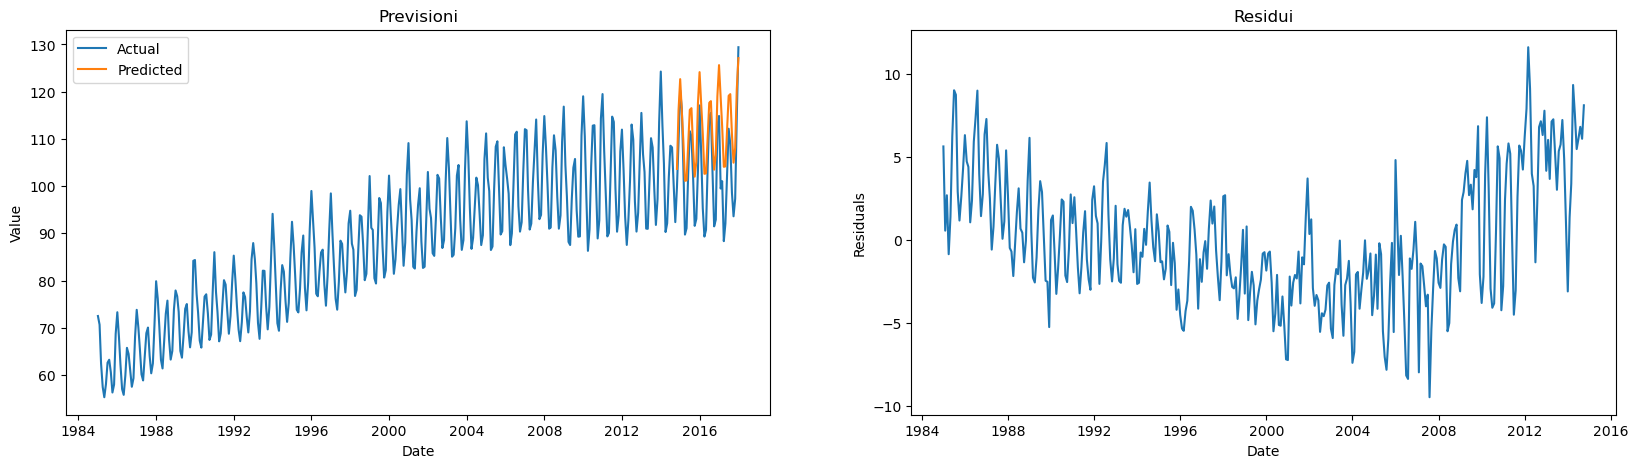

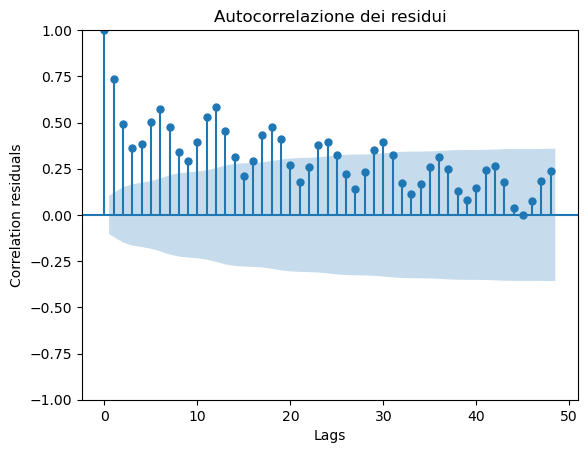

In [48]:
# Indichiamo la dimensione del test set
test_set_size = int(df.shape[0]*0.10)

# Creiamo il train e test set
Y_train = df_regr['value'].iloc[:-test_set_size]
X_train = df_regr[['time', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12']].iloc[:-test_set_size]
X_train = sm.add_constant(X_train)

Y_test = df_regr['value'].iloc[-test_set_size:]
X_test = df_regr[['time', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12']].iloc[-test_set_size:]
X_test = sm.add_constant(X_test)

# Creiamo il modello di regressione
model = sm.OLS(Y_train,X_train)
results = model.fit()

# Prendiamo le previsioni
predictions = results.predict(X_test)

fig, ax = plt.subplots(1,2,figsize=(20, 5))

# Plot delle previsioni
ax[0].plot(df['date'], df['value'])
ax[0].plot(df['date'].iloc[-test_set_size:], predictions)
ax[0].set_title('Previsioni')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Value')
ax[0].legend(['Actual', 'Predicted'])

# Plot dei residui
residuals=(results.predict(X_train) - Y_train)
ax[1].plot(residuals)
ax[1].set_title('Residui')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Residuals')

# Correlogramma dei residui
plot_acf(results.resid,lags=48)
plt.ylabel('Correlation residuals')
plt.xlabel('Lags')
plt.title('Autocorrelazione dei residui')
plt.show()

# Rendiamo la serie stazionaria
Utilizzando la differenza del k-lag togliamo sia la tendenza che la stagionalità

Text(0.5, 0, 'Lags')

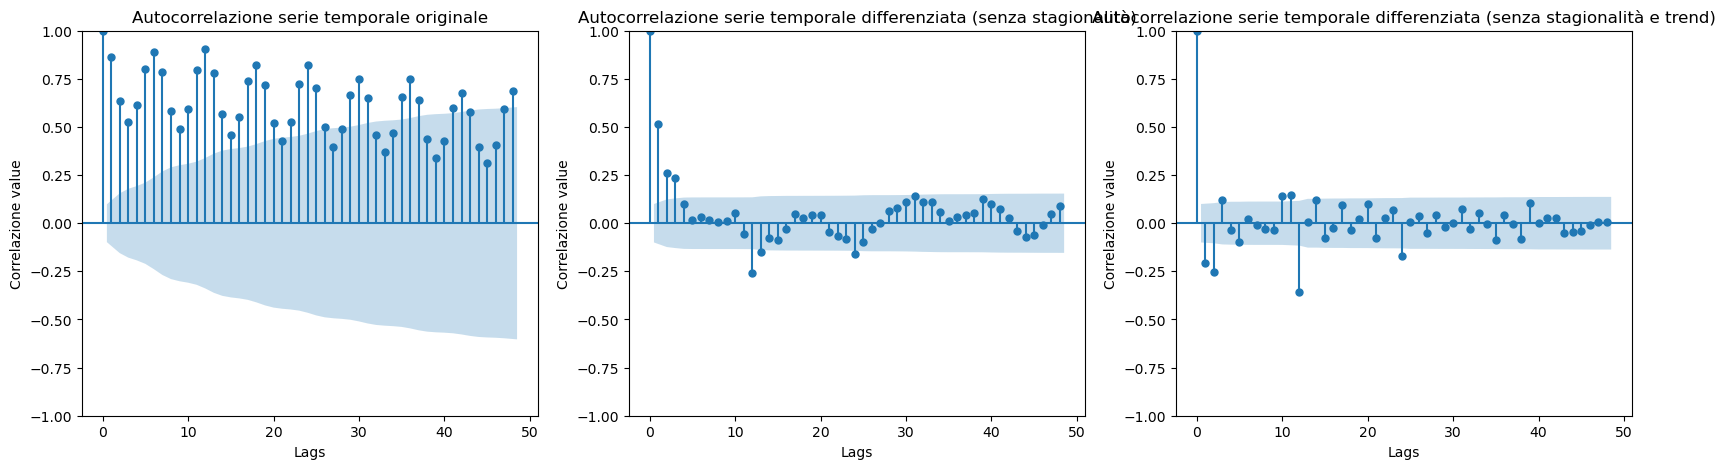

In [49]:
fig, ax = plt.subplots(1,3,figsize=(20, 5))

plot_acf(df["value"],lags=48,ax=ax[0])
ax[0].set_title("Autocorrelazione serie temporale originale")
ax[0].set_ylabel("Correlazione value")
ax[0].set_xlabel("Lags")

# Applichiamo la differenziazione 12 per eliminare la stagionalità
plot_acf(df["value"].diff(12).dropna(),lags=48,ax=ax[1])
ax[1].set_title("Autocorrelazione serie temporale differenziata (senza stagionalità)")
ax[1].set_ylabel("Correlazione value")
ax[1].set_xlabel("Lags")

# Applichiamo la differenziazione 1 per eliminare il trend
plot_acf(df["value"].diff(12).diff(1).dropna(),lags=48,ax=ax[2])
ax[2].set_title("Autocorrelazione serie temporale differenziata (senza stagionalità e trend)")
ax[2].set_ylabel("Correlazione value")
ax[2].set_xlabel("Lags")

Statistica del test ADF: -8.022039209985007
P-value: 2.0639252090771793e-12
Critical Values:
	1%: -3.45
	5%: -2.87
	10%: -2.57
La serie è stazionaria


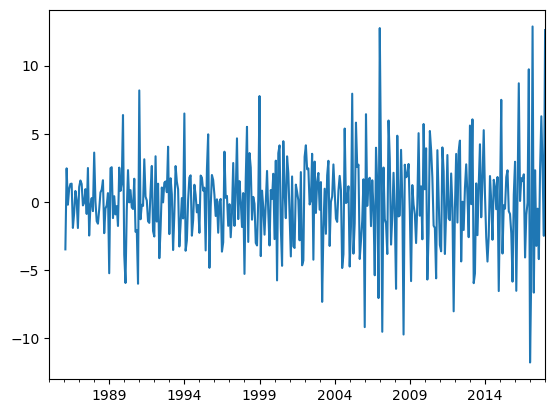

In [50]:
df["value_no_cycles_no_trend"] = df["value"].diff(12).diff(1)
df["value_no_cycles_no_trend"].plot()
test_ADF(df["value_no_cycles_no_trend"].dropna())

# Modello Autoregressivo
Nel modello autoregressivo usiamo la serie temporale togliendo solo la tendenza, ma mantenendo la stagionalità.  
In questo modo il modello sarà in grado di allenarsi nei vari periodi della serie.

Statistica del test ADF: -7.104890882267285
P-value: 4.077786565540049e-10
Critical Values:
	1%: -3.45
	5%: -2.87
	10%: -2.57
La serie è stazionaria


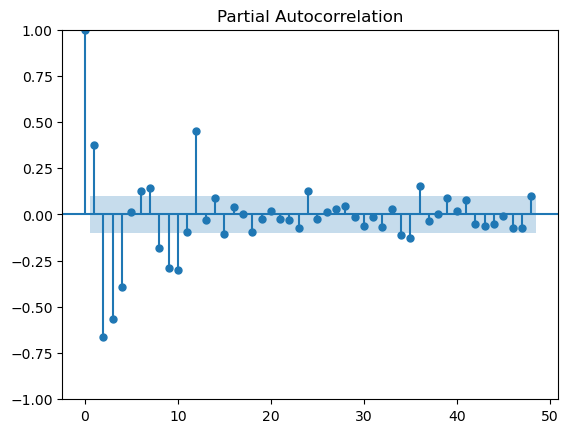

In [51]:
df["value_no_trend"] = df["value"].diff(1)
plot_pacf(df["value_no_trend"].dropna(),lags=48)
test_ADF(df["value_no_trend"].dropna())
plt.show()

In [52]:
# Creiamo il train e test set
train = df.iloc[:-test_set_size]
test = df.iloc[-test_set_size:]

# Selezioniamo il miglior ordine per il modello AR con stagionalità
selector = ar_select_order(train['value_no_trend'].dropna(), 15, seasonal=True, period=12)
model = AutoReg(train['value_no_trend'].dropna(), lags=selector.ar_lags, seasonal=True, period=12).fit()

/var/folders/x5/xvsgcbj13_s9tdm6w_4zqg9m0000gn/T/ipykernel_27967/2513880990.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['forecasts'] = forecasts


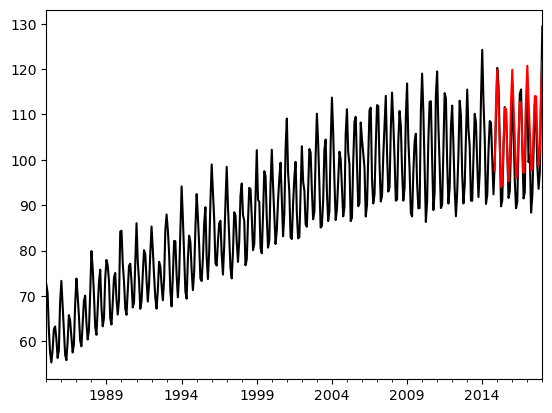

In [53]:
transformed_forecasts = list(model.forecast(steps=test_set_size))

# Creiamo le previsioni aggiungendo i valori precedenti
forecasts = []
for idx in range(len(test)):
    if idx == 0:
        forecast = transformed_forecasts[idx] + train['value'].iloc[-1]
    else:
        forecast = transformed_forecasts[idx] + forecasts[idx-1]
    forecasts.append(forecast)

test['forecasts'] = forecasts

df['value'].plot(color='k')
test['forecasts'].plot(color='red')
plt.show()

Text(0.5, 1.0, 'Autocorrelazione dei residui su AR model')

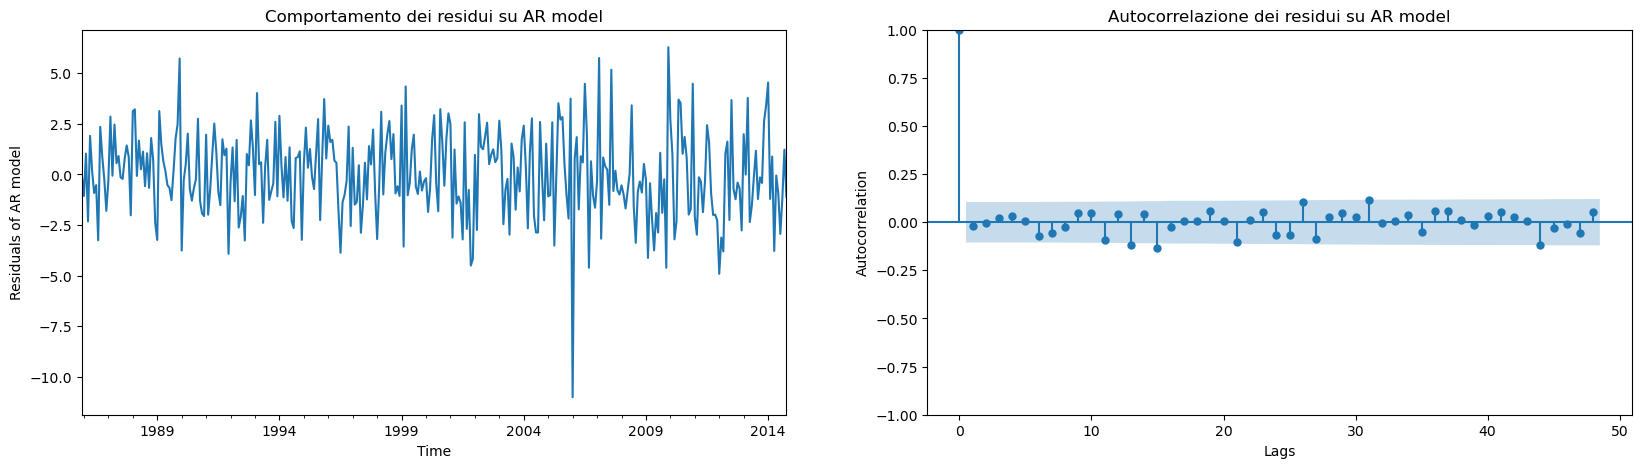

In [54]:
fig, ax = plt.subplots(1,2,figsize=(20, 5))

# Plot delle previsioni
residuals=(train['value_no_trend'] - model.fittedvalues).dropna()
residuals.plot(ax=ax[0])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Residuals of AR model')
ax[0].set_title('Comportamento dei residui su AR model')

# Correlogramma dei residui
plot_acf(residuals,lags=48,ax=ax[1])
ax[1].set_ylabel('Autocorrelation')
ax[1].set_xlabel('Lags')
ax[1].set_title('Autocorrelazione dei residui su AR model')

# Conclusioni
Per concludere l'analisi, abbiamo visto la serie temporale provando a prevederla sia con un modello di regressione standard e sia con un modello autoregressivo.  
La serie temporale non presentava valori mancanti, aveva una stagionalità e una tendenza crescente.
Il rumore non è stato particolarmente gestito, perchè anche con una trasformazione box-cox il risultato del modello autoregressivo non cambiava significativamente.  
Facendo un confronto tra i due modelli di previsioni, l'autoregressivo risulta più preciso. Questo si può confermare guardando i correlogramma dei residui ottenuti dai modelli.